In [ ]:
import json
import os
import pandas as pd
import nltk
import json_lines
from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize 
from collections import Counter
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import re;
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import sentiwordnet as swn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    stop_words = set(stopwords.words('english'))
    for word, tag in tags:
        if word.lower() not in stop_words:
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist


wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew


# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
    # function to calculate polarity
def getPolarity(review):
        return TextBlob(review).sentiment.polarity


# -1 - Negative, 0 - Neutral, 1 - positive 
# function to analyze the reviews
def analysis(score):
    if score < 0:
        return -1
    elif score == 0:
        return 0
    else:
        return 1


def textblob_senti(dataframe):
    dataframe['POS tagged'] = dataframe['text'].apply(token_stop_pos)
    dataframe['Lemma'] = dataframe['POS tagged'].apply(lemmatize)

    fin_data = pd.DataFrame(dataframe[['text', 'Lemma','date']])

    fin_data['Polarity'] = fin_data['Lemma'].apply(getPolarity) 
    fin_data['text_blob'] = fin_data['Polarity'].apply(analysis)

    # count number of positive and negative sentiment tweets for each date
    senti_counts = fin_data.groupby(['date', 'text_blob'])['text_blob'].count().unstack(fill_value=0)
    senti_counts.columns = ['Negative', 'Neutral', 'Positive']
    senti_counts.reset_index(inplace=True)

    return senti_counts



In [ ]:
import pandas as pd

# define the path to the cleaned dataset
data_path = '/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/output final/2-sucessfulmicrosoft 2022,2023,better corelation/cleaned_MSFT.csv'

# read in the cleaned dataset
cleaned_data = pd.read_csv(data_path)
cleaned_data['date'] = pd.to_datetime(cleaned_data['created_at']).dt.normalize()

# apply textblob_senti function to the dataset
df_sentiment = textblob_senti(cleaned_data)

# save the output to a csv file
df_sentiment.to_csv('sentiment_scorescount.csv', index=False)


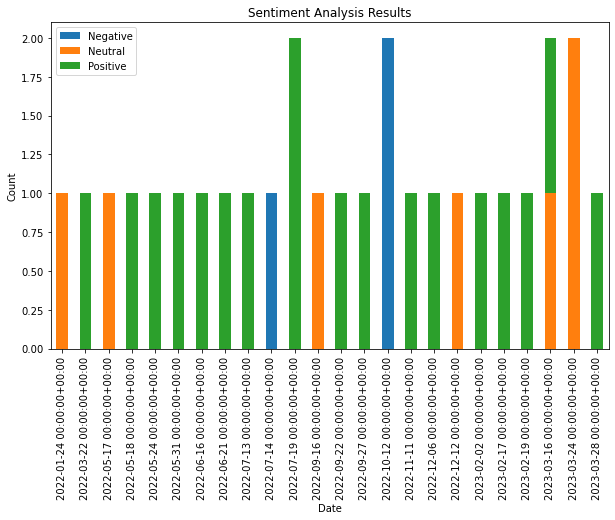

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# load the CSV file
df = pd.read_csv('sentiment_scorescount.csv')

# set the date as the index
df = df.set_index('date')

# plot the bar chart
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('Sentiment Analysis Results')
plt.show()


/var/folders/cv/kqtmxty13dv9pvwg87pty1zc0000gn/T/ipykernel_33295/3382089976.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([d.strftime('%y-%m') for d in df['date']], rotation=45)


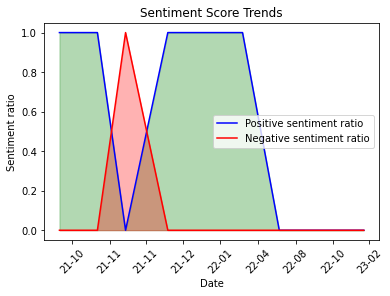

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read in the sentiment score csv file
df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/AMZNsentiment_scorescount.csv', parse_dates=['date'])

# Calculate the total count of sentiment scores for each date
df['total_count'] = df['Negative'] + df['Neutral'] + df['Positive']

# Calculate the ratio of positive and negative sentiment scores for each date
df['positive_ratio'] = df['Positive'] / df['total_count']
df['negative_ratio'] = df['Negative'] / df['total_count']

# Plot the sentiment score trends over time
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(df['date'], df['positive_ratio'], color='blue', label='Positive sentiment ratio')
ax.plot(df['date'], df['negative_ratio'], color='red', label='Negative sentiment ratio')
ax.fill_between(df['date'], df['positive_ratio'], color='green', alpha=0.3)
ax.fill_between(df['date'], df['negative_ratio'], color='red', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Sentiment ratio')
ax.set_title('Sentiment Score Trends')
ax.set_xticklabels([d.strftime('%y-%m') for d in df['date']], rotation=45)
ax.legend()
plt.show()


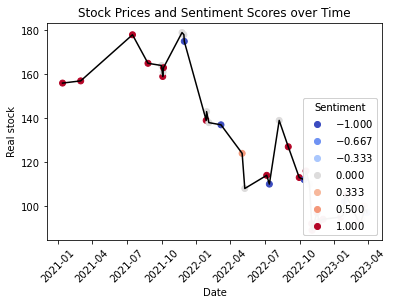

In [ ]:
import matplotlib.pyplot as plt

# read in the csv file and group by date
df = pd.read_csv("/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/output/randomrealstock_AMZN.csv")

df["date"] = pd.to_datetime(df["date"])
df = df.groupby("date").mean().reset_index()

# create scatter plot
fig, ax = plt.subplots()
scatter = ax.scatter(df["date"], df["Adj Close"], c=df["text_blob"], cmap='coolwarm')

# add legend
legend = ax.legend(*scatter.legend_elements(), loc="lower right", title="Sentiment")
ax.add_artist(legend)

# create line plot of stock prices
ax.plot(df["date"], df["Adj Close"], color="black")

# set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Real stock")
ax.set_title("Stock Prices and Sentiment Scores over Time")
plt.xticks(rotation=45)
# show plot
plt.show()


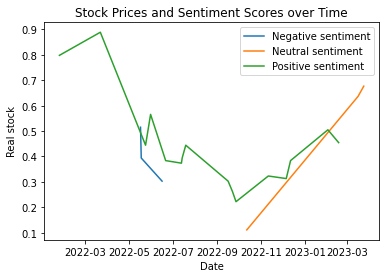

In [ ]:
import matplotlib.pyplot as plt

# read in the csv file
df = df = pd.read_csv("/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/output/realstock_MSFT.csv")

# convert date column to datetime
df["date"] = pd.to_datetime(df["date"])

# create separate dataframes for each sentiment category
df_negative = df[df["vader_sentiment"] == 0]
df_neutral = df[df["vader_sentiment"] == 0.5]
df_positive = df[df["vader_sentiment"] == 1]

# create line plot
fig, ax = plt.subplots()
ax.plot(df_negative["date"], df_negative["Adj Close"], label="Negative sentiment")
ax.plot(df_neutral["date"], df_neutral["Adj Close"], label="Neutral sentiment")
ax.plot(df_positive["date"], df_positive["Adj Close"], label="Positive sentiment")

# set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Real stock")
ax.set_title("Stock Prices and Sentiment Scores over Time")

# add legend
ax.legend()

# show plot
plt.show()


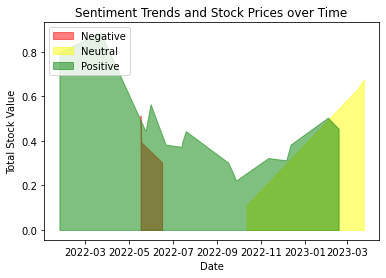

In [ ]:
import matplotlib.pyplot as plt

# read in the csv file
df = df = pd.read_csv("/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/output final/2-sucessfulmicrosoft 2022,2023,better corelation/realstock_MSFT.csv")

df["date"] = pd.to_datetime(df["date"])

# separate the data by sentiment category
neg_df = df[df["vader_sentiment"] == 0]
neu_df = df[df["vader_sentiment"] == 0.5]
pos_df = df[df["vader_sentiment"] == 1]

# create the stacked area plot
fig, ax = plt.subplots()
ax.fill_between(neg_df["date"], neg_df["Adj Close"], color="red", alpha=0.5, label="Negative")
ax.fill_between(neu_df["date"], neu_df["Adj Close"], color="yellow", alpha=0.5, label="Neutral")
ax.fill_between(pos_df["date"], pos_df["Adj Close"], color="green", alpha=0.5, label="Positive")

# set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Total Stock Value")
ax.set_title("Sentiment Trends and Stock Prices over Time")

# add legend
ax.legend(loc="upper left")

# show plot
plt.show()


/var/folders/cv/kqtmxty13dv9pvwg87pty1zc0000gn/T/ipykernel_1710/3625335717.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([d.strftime('%y-%m') for d in df['date']], rotation=45)


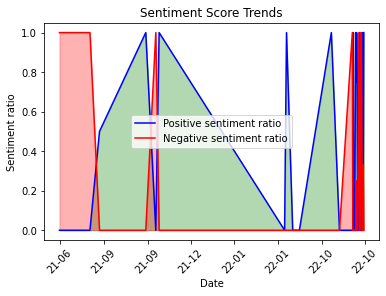

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read in the sentiment score csv file
df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/MSFTsentiment_scorescount.csv', parse_dates=['date'])

# Calculate the total count of sentiment scores for each date
df['total_count'] = df['Negative'] + df['Neutral'] + df['Positive']

# Calculate the ratio of positive and negative sentiment scores for each date
df['positive_ratio'] = df['Positive'] / df['total_count']
df['negative_ratio'] = df['Negative'] / df['total_count']

# Plot the sentiment score trends over time
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(df['date'], df['positive_ratio'], color='blue', label='Positive sentiment ratio')
ax.plot(df['date'], df['negative_ratio'], color='red', label='Negative sentiment ratio')
ax.fill_between(df['date'], df['positive_ratio'], color='green', alpha=0.3)
ax.fill_between(df['date'], df['negative_ratio'], color='red', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Sentiment ratio')
ax.set_title('Sentiment Score Trends')
ax.set_xticklabels([d.strftime('%y-%m') for d in df['date']], rotation=45)
ax.legend()
plt.show()


<Figure size 720x432 with 0 Axes>

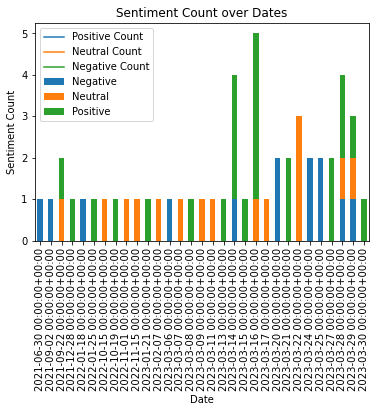

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/MSFTsentiment_scorescount.csv', parse_dates=['date'])

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Set 'date' column as index
df.set_index('date', inplace=True)

# Create a new figure and set its size
plt.figure(figsize=(10, 6))
df.plot(kind='bar', stacked=True)
# Plot positive and negative counts as two separate lines
plt.plot(df['Positive'], label='Positive Count')
plt.plot(df['Neutral'], label='Neutral Count')
plt.plot(df['Negative'], label='Negative Count')

# Set x-label, y-label, and title
plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.title('Sentiment Count over Dates')

# Add legend
plt.legend()

# Show the plot
plt.show()


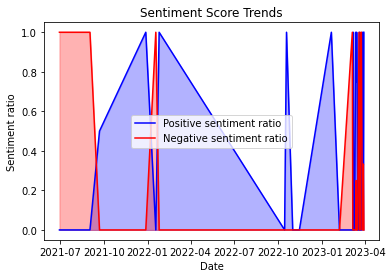

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read in the sentiment score csv file
df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/MSFTsentiment_scorescount.csv', parse_dates=['date'])

# Calculate the total count of sentiment scores for each date
df['total_count'] = df['Negative'] + df['Neutral'] + df['Positive']

# Calculate the ratio of positive and negative sentiment scores for each date
df['positive_ratio'] = df['Positive'] / df['total_count']
df['negative_ratio'] = df['Negative'] / df['total_count']

# Plot the sentiment score trends over time
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(df['date'], df['positive_ratio'], color='blue', label='Positive sentiment ratio')
ax.plot(df['date'], df['negative_ratio'], color='red', label='Negative sentiment ratio')
ax.fill_between(df['date'], df['positive_ratio'], color='blue', alpha=0.3)
ax.fill_between(df['date'], df['negative_ratio'], color='red', alpha=0.3)

# Format the x-axis tick labels to display the dates in mm-yy format
date_fmt = '%m-%y'


ax.set_xlabel('Date')
ax.set_ylabel('Sentiment ratio')
ax.set_title('Sentiment Score Trends')
ax.legend()
plt.show()


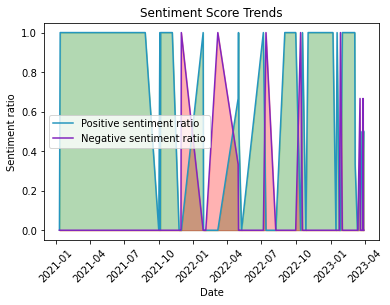

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read in the sentiment score csv file
df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/AMZNsentiment_scorescount.csv', parse_dates=['date'])

# Calculate the total count of sentiment scores for each date
df['total_count'] = df['Negative'] + df['Neutral'] + df['Positive']

# Calculate the ratio of positive and negative sentiment scores for each date
df['positive_ratio'] = df['Positive'] / df['total_count']
df['negative_ratio'] = df['Negative'] / df['total_count']

# Plot the sentiment score trends over time
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(df['date'], df['positive_ratio'], color='#2596BE', label='Positive sentiment ratio')
ax.plot(df['date'], df['negative_ratio'], color='#8225BE', label='Negative sentiment ratio')
ax.fill_between(df['date'], df['positive_ratio'], color='green', alpha=0.3)
ax.fill_between(df['date'], df['negative_ratio'], color='red', alpha=0.3)
plt.xticks(rotation=45)
# Format the x-axis tick labels to display the dates in mm-yy format
date_fmt = '%m-%y'

ax.set_xlabel('Date')
ax.set_ylabel('Sentiment ratio')
ax.set_title('Sentiment Score Trends')
ax.legend()
plt.show()


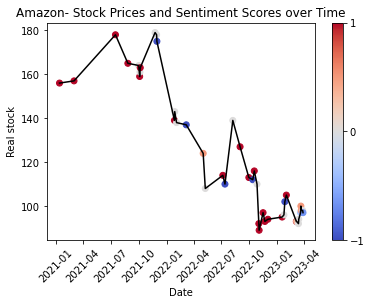

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# read in the csv file and group by date
df = pd.read_csv("/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/output/randomrealstock_AMZN.csv")

df["date"] = pd.to_datetime(df["date"])
df = df.groupby("date").mean().reset_index()

# create scatter plot
fig, ax = plt.subplots()
scatter = ax.scatter(df["date"], df["Adj Close"], c=df["text_blob"], cmap='coolwarm')

# create colorbar axis and set ticks
cbar = plt.colorbar(scatter)
cbar.set_ticks([-1, 0, 1])

# create line plot of stock prices
ax.plot(df["date"], df["Adj Close"], color="black")

# set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Real stock")
ax.set_title("Amazon- Stock Prices and Sentiment Scores over Time")

# rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# show plot
plt.show()


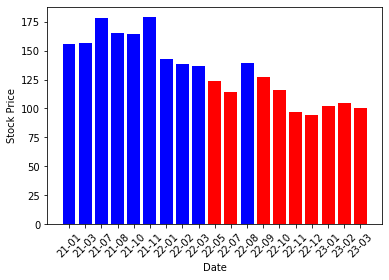

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/output/sucessfulrealstock_AMZN.csv')
# Create lists for dates and stock prices
df['date'] = pd.to_datetime(df['date']).dt.strftime('%y-%m')
dates = df['date'].tolist()
stock_prices = df['Adj Close'].tolist()
colors = ['blue' if price > 130 else 'r' for price in stock_prices]
# Create the figure and axis objects
fig, ax = plt.subplots()

# Plot the stock prices with dates as the x-axis
ax.bar(dates, stock_prices,color=colors)

# Set the x-axis label to 'Date' and y-axis label to 'Stock Price'
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')

# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


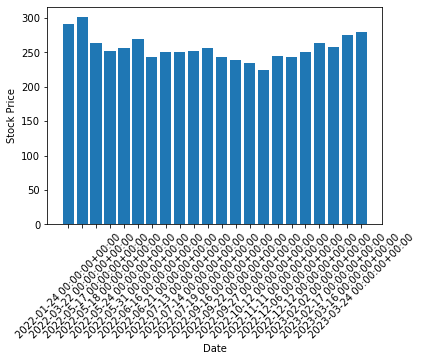

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read in the data from the CSV file
df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/output/sucessfulrealstock_MSFT.csv')

# Extract the dates and stock prices
dates = df['date'].tolist()
stock_prices = df['Adj Close'].tolist()

# Create the figure and axis objects
fig, ax = plt.subplots()

# Create the bar chart
ax.bar(dates, stock_prices)

# Set the x-axis label to 'Date' and y-axis label to 'Stock Price'
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')

date_fmt = '%m-%y'
# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
#sucessful people topics
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load the dataset
tweets_df = df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/outputfinal/sucessfulpeoplemsftwith techlayoffs/cleaned_MSFT.csv')
tweets_df = tweets_df.dropna(subset=['text'])

# Preprocess the text data
stop_words = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(tweets_df['text'])

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online')
lda_model.fit(X)

# Get the topics and associated keywords
keywords = np.array(vectorizer.get_feature_names())
topic_keywords = []
for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:10]
    topic_keywords.append(keywords.take(top_keyword_locs))

# Print the topics and associated keywords
for i, topic in enumerate(topic_keywords):
    print("Topic %d:" % (i))
    print(" ".join(topic))


Topic 0:
amp microsoft congratulations customers new thank advance announcing hybrid share
Topic 1:
much thanks enjoyed willow changing quest quantum appreciate future year
Topic 2:
better interns journey amp beginning linkedin action truly passion cup
Topic 3:
amp great online courses alwayscompete addition gohawks students love ediscovery
Topic 4:
good lost fascinating predictions talented researchers cloud workingfamilychamps means nano
Topic 5:
power azure customer world entire apply africa microsoft building center
Topic 6:
amp impressive summer create help interns people contributions proud mobile
Topic 7:
connecting pleasure invite seek always value differences pride much team
Topic 8:
cloud visiting government professional leading thanks transformed microsoft linkedin read
Topic 9:
cloud welcome veterans microsoft thrilled amp customers createcultivatesea partners across


/Users/akankshacheeti/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#random people topics
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load the dataset
tweets_df = df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/outputfinal/MSFTrandom usertimelines2018 to 2022/cleaned_MSFT.csv')
tweets_df = tweets_df.dropna(subset=['text'])

# Preprocess the text data
stop_words = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(tweets_df['text'])

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online')
lda_model.fit(X)

# Get the topics and associated keywords
keywords = np.array(vectorizer.get_feature_names())
topic_keywords = []
for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:10]
    topic_keywords.append(keywords.take(top_keyword_locs))

# Print the topics and associated keywords
for i, topic in enumerate(topic_keywords):
    print("Topic %d:" % (i))
    print(" ".join(topic))


Topic 0:
loose generative cybersecurity lets system management lms built learning raises
Topic 1:
microsoft notion launches competitor loop preview teeth public germany kicks
Topic 2:
mulls investigation aws ofcom services crosshairs market introducing galaxy edge
Topic 3:
surface focused azure managed enterprise service comes chatgpt hoping make
Topic 4:
performance promises rebuilt faster ground teams algae microsoft bets mitigate
Topic 5:
powered new ai host gets sweet features microsoft slips ads
Topic 6:
app ios keyboard integrates swiftkey android adding zoom kickstarts compete
Topic 7:
snapchat teams access meetings lenses tech zero google microsoft kesteven
Topic 8:
apps build microsoft store games mobile new platform banks copilot
Topic 9:
microsoft bing wtf narrows probe ai activision along using gpt


/Users/akankshacheeti/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load the dataset
tweets_df = df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/outputfinal/sucessfulpeoplemsftwith techlayoffs/cleaned_MSFT.csv')
tweets_df = tweets_df.dropna(subset=['text'])

# Preprocess the text data
stop_words = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(tweets_df['text'])

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online')
lda_model.fit(X)

# Get the topics and associated keywords
keywords = np.array(vectorizer.get_feature_names())
topic_keywords = []
for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:10]
    topic_keywords.append(keywords.take(top_keyword_locs))

# Print the topics and associated keywords
for i, topic in enumerate(topic_keywords):
    print("Topic %d:" % (i))
    print(" ".join(topic))
    
# Assign each tweet to a topic
doc_topics = lda_model.transform(X)
tweets_df['topic'] = doc_topics.argmax(axis=1)

# Print the top 10 tweets for each topic
n_top_tweets = 10
for i, topic in enumerate(topic_keywords):
    print(f"Top {n_top_tweets} tweets for Topic {i}:")
    top_tweets_idx = doc_topics[:, i].argsort()[::-1][:n_top_tweets]
    for idx in top_tweets_idx:
        print(f"\t{tweets_df.iloc[idx]['text']}")


/Users/akankshacheeti/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:
proud better life importance sharing workplace thoughts diversity giving making
Topic 1:
congratulations much thanks newest summer impressive thank becoming team connecting
Topic 2:
help amp new time microsoft first cloud azure technology yesterday
Topic 3:
amp microsoft way customers today love thank community students health
Topic 4:
veterans amp great empowering done spend much sapphirenow appreciate researchers
Topic 5:
cloud government leading professional orgs sizes accessible world amp together
Topic 6:
lost research asta digigirlz girls introducing microsoft family send condolences
Topic 7:
amp quantum quest changing future see fight rt inspiring story
Topic 8:
cloud welcome microsoft complete announcing data maximize generation value workingfamilychamps
Topic 9:
thrilled welcome createcultivatesea beginning tech journey linkedin willow together enjoyed
Top 10 tweets for Topic 0:
	thank convening critical conversation cybersecurity microsoft invest billion advance secu

/var/folders/cv/kqtmxty13dv9pvwg87pty1zc0000gn/T/ipykernel_21582/2495303162.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['topic'] = doc_topics.argmax(axis=1)


Topic 0:
pleasure connecting always amp dev os much developer universal milestone
Topic 1:
amp today customers empowering great microsoft flow veterans making lost
Topic 2:
world leading professional pride everyone amp quest quantum seek invite
Topic 3:
much thanks interns work summer impressive microsoft beginning linkedin learned
Topic 4:
cloud complete microsoft government next office alwayscompete addition gohawks generation
Topic 5:
thrilled welcome teams createcultivatesea microsoft leadership industry transformed induction beyond
Topic 6:
help amp cloud microsoft welcome make online students courses new
Topic 7:
better results engineers valuing ideas differences products proud amp microsoft
Topic 8:
thanks visiting thoughts workplace diversity team importance amp inspiration amy
Topic 9:
amp tech interns ceo becoming congratulations newest data devices maximize
Topic 0:
introducing galaxy edge company th free gaming boosteroid signs another
Topic 1:
teams microsoft wtf meetings 

/Users/akankshacheeti/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/akankshacheeti/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


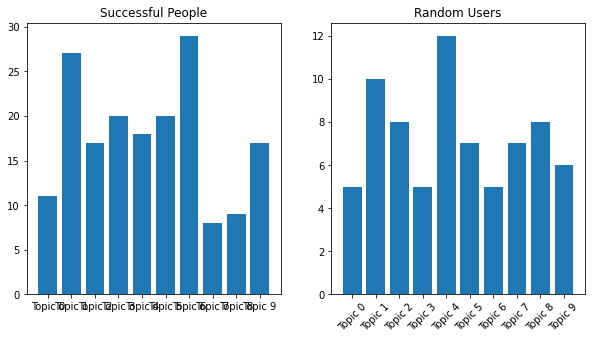

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Load the successful people dataset
tweets_df1 = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/outputfinal/sucessfulpeoplemsftwith techlayoffs/cleaned_MSFT.csv')
tweets_df1 = tweets_df1.dropna(subset=['text'])

# Preprocess the text data
stop_words = stopwords.words('english')
vectorizer1 = TfidfVectorizer(stop_words=stop_words)
X1 = vectorizer1.fit_transform(tweets_df1['text'])

# Fit the LDA model
lda_model1 = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online')
lda_model1.fit(X1)

# Get the topics and associated keywords
keywords1 = np.array(vectorizer1.get_feature_names())
topic_keywords1 = []
for topic_weights in lda_model1.components_:
    top_keyword_locs = (-topic_weights).argsort()[:10]
    topic_keywords1.append(keywords1.take(top_keyword_locs))

# Print the topics and associated keywords
for i, topic in enumerate(topic_keywords1):
    print("Topic %d:" % (i))
    print(" ".join(topic))
    
# Load the random user dataset
tweets_df2 = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/outputfinal/MSFTrandom usertimelines2018 to 2022/cleaned_MSFT.csv')
tweets_df2 = tweets_df2.dropna(subset=['text'])

# Preprocess the text data
vectorizer2 = TfidfVectorizer(stop_words=stop_words)
X2 = vectorizer2.fit_transform(tweets_df2['text'])

# Fit the LDA model
lda_model2 = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online')
lda_model2.fit(X2)

# Get the topics and associated keywords
keywords2 = np.array(vectorizer2.get_feature_names())
topic_keywords2 = []
for topic_weights in lda_model2.components_:
    top_keyword_locs = (-topic_weights).argsort()[:10]
    topic_keywords2.append(keywords2.take(top_keyword_locs))

# Print the topics and associated keywords
for i, topic in enumerate(topic_keywords2):
    print("Topic %d:" % (i))
    print(" ".join(topic))
    
# Create a bar plot to compare the topic distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
topic_labels = ['Topic {}'.format(i) for i in range(10)]
topic_counts1 = np.zeros(10)
for topic_weights in lda_model1.transform(X1):
    topic_counts1[np.argmax(topic_weights)] += 1
ax1.bar(topic_labels, topic_counts1)
ax1.set_title('Successful People')
topic_counts2 = np.zeros(10)
for topic_weights in lda_model2.transform(X2):
    topic_counts2[np.argmax(topic_weights)] += 1
ax2.bar(topic_labels, topic_counts2)
ax2.set_title('Random Users')
plt.xticks(rotation=45)
plt.show()


Topic 0: Company Performance
creating amp new apps yesterday forward help inclusion opportunity sketched
Topic 1: Stock Market Trends
government teams transformed tasks important work read linkedin microsoft organize
Topic 2: Technology Innovation
amp truly flow microsoft dynamics powerapps recognize today beyond talented
Topic 3: Business Strategy
cloud world microsoft complete transform leading professional willow lost enjoyed
Topic 4: Product Development
time veterans world changing quantum quest invite seek future cloud
Topic 5: Customer Satisfaction
amp better thanks president sharing contributions honored tech leadership induction
Topic 6: Industry News
garage roots grass action start innovation culture new features headspace
Topic 7: Job Opportunities
impressive summer cloud online courses interns orgs sizes love students
Topic 8: Financial Outlook
welcome thrilled microsoft together createcultivatesea ceo linkedin beginning across becoming
Topic 9: Partnership and Collaboration

/Users/akankshacheeti/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/cv/kqtmxty13dv9pvwg87pty1zc0000gn/T/ipykernel_7055/725993188.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(topic_names, rotation=45, ha='right')


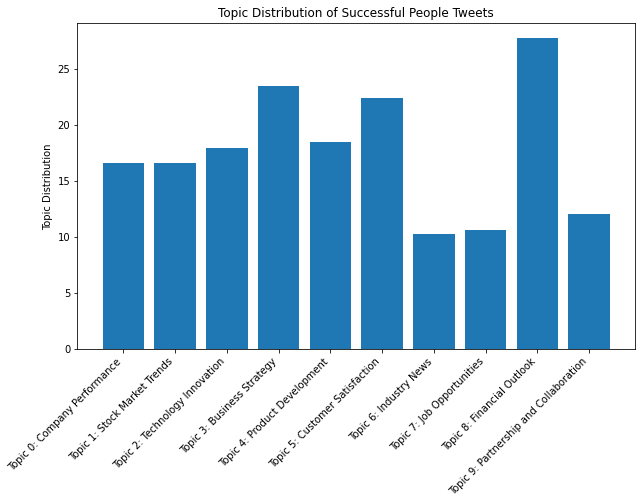

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Load the dataset
tweets_df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/outputfinal/sucessfulpeoplemsftwith techlayoffs/cleaned_MSFT.csv')
tweets_df = tweets_df.dropna(subset=['text'])

# Preprocess the text data
stop_words = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(tweets_df['text'])

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online')
lda_model.fit(X)

# Get the topics and associated keywords
keywords = np.array(vectorizer.get_feature_names())
topic_keywords = []
for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:10]
    topic_keywords.append(keywords.take(top_keyword_locs))

# Assign topic names
topic_names = ['Topic 0: Company Performance', 'Topic 1: Stock Market Trends', 'Topic 2: Technology Innovation', 'Topic 3: Business Strategy', 'Topic 4: Product Development', 'Topic 5: Customer Satisfaction', 'Topic 6: Industry News', 'Topic 7: Job Opportunities', 'Topic 8: Financial Outlook', 'Topic 9: Partnership and Collaboration']

# Print the topics and associated keywords
for i, topic in enumerate(topic_keywords):
    print(topic_names[i])
    print(" ".join(topic))

# Create a bar plot of topic distribution
topic_distribution1 = lda_model.transform(X)
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(topic_names, topic_distribution1.sum(axis=0))
ax.set_xticklabels(topic_names, rotation=45, ha='right')
ax.set_ylabel('Topic Distribution')
ax.set_title('Topic Distribution of Successful People Tweets')
plt.show()


/Users/akankshacheeti/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


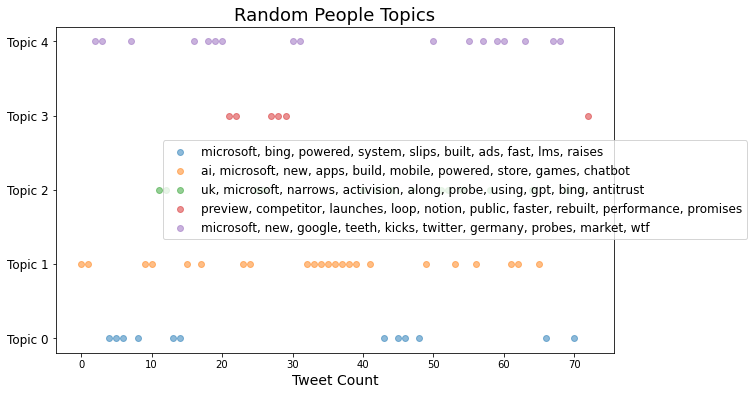

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Load the dataset
tweets_df = df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/outputfinal/MSFTrandom usertimelines2018 to 2022/cleaned_MSFT.csv')
#tweets_df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/outputfinal/sucessfulpeoplemsftwith techlayoffs/cleaned_MSFT.csv')

tweets_df = tweets_df.dropna(subset=['text'])

# Preprocess the text data
stop_words = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(tweets_df['text'])

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online')
lda_model.fit(X)

# Get the topics and associated keywords
keywords = np.array(vectorizer.get_feature_names())
topic_keywords = []
for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:10]
    topic_keywords.append(keywords.take(top_keyword_locs))

# Assign topics to the documents
topic_assignments = lda_model.transform(X)
topics = np.argmax(topic_assignments, axis=1)

# Plot the topics
fig, ax = plt.subplots(figsize=(10,6))
for topic in range(lda_model.n_components):
    topic_keywords_str = ", ".join(topic_keywords[topic])
    topic_mask = (topics == topic)
    topic_tweets = tweets_df[topic_mask]['text']
    ax.scatter(topic_tweets.index, [topic]*len(topic_tweets), label=topic_keywords_str, alpha=0.5)
ax.set_yticks(range(lda_model.n_components))
ax.set_yticklabels(["Topic {}".format(i) for i in range(lda_model.n_components)], fontsize=12)
ax.set_xlabel("Tweet Count", fontsize=14)
ax.set_title("Random People Topics", fontsize=18)
ax.legend(loc="center right", bbox_to_anchor=(1.25, 0.5), fontsize=12)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load the dataset
tweets_df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/outputfinal/MSFTrandom usertimelines2018 to 2022/cleaned_MSFT.csv')
tweets_df = tweets_df.dropna(subset=['text'])

# Preprocess the text data
stop_words = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(tweets_df['text'])

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online')
lda_model.fit(X)

# Define topic names
topic_names = {
    0: "Product Updates",
    1: "Company Performance",
    2: "Tech Industry",
    3: "Social Responsibility",
    4: "Future Outlook",
    5: "Workplace Culture",
    6: "Investment Opportunities",
    7: "Market Analysis",
    8: "Customer Satisfaction",
    9: "Financial Results"
}

# Get the topics and associated keywords
keywords = np.array(vectorizer.get_feature_names())
topic_keywords = []
for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:10]
    topic_keywords.append(keywords.take(top_keyword_locs))

# Print the topics and associated keywords with topic names
for i, topic in enumerate(topic_keywords):
    print("Topic {}: {}".format(i, topic_names[i]))
    print(" ".join(topic))


Topic 0: Product Updates
teeth twitter kicks apps wtf microsoft week games tiktok goes
Topic 1: Company Performance
new microsoft brings image dall slack creator compete adding zoom
Topic 2: Tech Industry
sweet daily crunch opens waitlist waives chatbot powered bing ai
Topic 3: Social Responsibility
surface enough defaults convince microsoft generate switch alt chatgpt model
Topic 4: Future Outlook
learning built raises management android ios microsoft system app lms
Topic 5: Workplace Culture
office hearts always quantum integrate easier classical computing makes minority
Topic 6: Investment Opportunities
tech probe activision narrows promises performance microsoft faster rebuilt teams
Topic 7: Market Analysis
stem footprint mitigate carbon bets growing algae would million went
Topic 8: Customer Satisfaction
ai market powered microsoft germany probes gets cybersecurity host generative
Topic 9: Financial Results
build microsoft notion competitor loop new launches preview public ai


/Users/akankshacheeti/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0: Company Performance
activision probe narrows antitrust uk free future us software ahead
Topic 1: Stock Market Trends
apps goes plan connect tiktok week store congress chatgpt games
Topic 2: Technology Innovation
ai bing powered microsoft new cybersecurity loose lets host generative
Topic 3: Business Strategy
teams access ground lenses rebuilt meetings snapchat promises performance faster
Topic 4: Product Development
microsoft build competitor launches notion preview twitter loop kicks teeth
Topic 5: Customer Satisfaction
market probes germany microsoft power edge crosshairs mulls aws services
Topic 6: Industry News
bug used patches windows ransomware attacks zero day microsoft gpt
Topic 7: Job Opportunities
sweet zoom calendly slack compete adding google features office hearts
Topic 8: Financial Outlook
doubles ethical easier makes computing lays classical team integrate quantum
Topic 9: Partnership and Collaboration
new microsoft techquickie creator brings image dall openai k

/Users/akankshacheeti/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/cv/kqtmxty13dv9pvwg87pty1zc0000gn/T/ipykernel_7055/604956947.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(topic_names, rotation=45, ha='right')


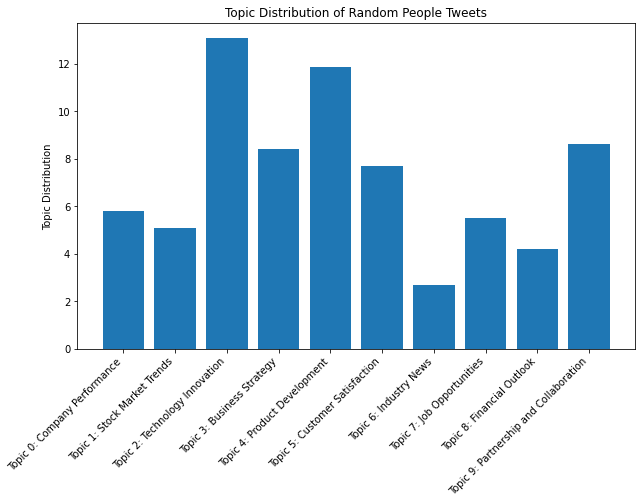

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Load the dataset
tweets_df = pd.read_csv('/Users/akankshacheeti/Documents/spring 2023/NLP/old project/NLP Project/outputfinal/MSFTrandom usertimelines2018 to 2022/cleaned_MSFT.csv')
tweets_df = tweets_df.dropna(subset=['text'])

# Preprocess the text data
stop_words = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(tweets_df['text'])

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online')
lda_model.fit(X)

# Get the topics and associated keywords
keywords = np.array(vectorizer.get_feature_names())
topic_keywords = []
for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:10]
    topic_keywords.append(keywords.take(top_keyword_locs))

# Assign topic names
topic_names = ['Topic 0: Company Performance', 'Topic 1: Stock Market Trends', 'Topic 2: Technology Innovation', 'Topic 3: Business Strategy', 'Topic 4: Product Development', 'Topic 5: Customer Satisfaction', 'Topic 6: Industry News', 'Topic 7: Job Opportunities', 'Topic 8: Financial Outlook', 'Topic 9: Partnership and Collaboration']

# Print the topics and associated keywords
for i, topic in enumerate(topic_keywords):
    print(topic_names[i])
    print(" ".join(topic))

# Create a bar plot of topic distribution
topic_distribution2 = lda_model.transform(X)
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(topic_names, topic_distribution2.sum(axis=0))
ax.set_xticklabels(topic_names, rotation=45, ha='right')
ax.set_ylabel('Topic Distribution')
ax.set_title('Topic Distribution of Random People Tweets')
plt.show()


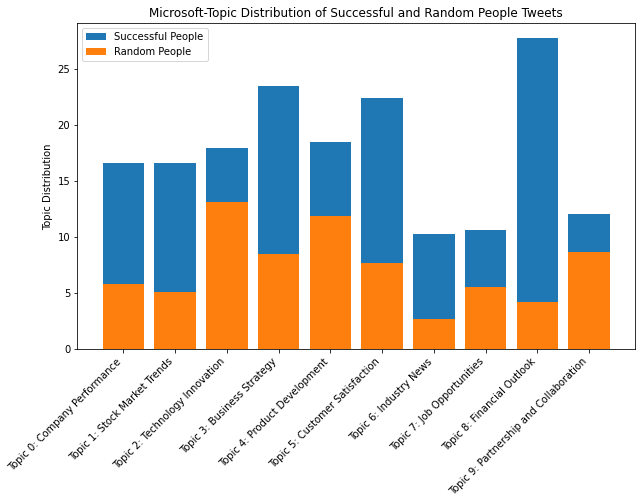

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(np.arange(len(topic_names)), topic_distribution1.sum(axis=0), label='Successful People')
ax.bar(np.arange(len(topic_names)), topic_distribution2.sum(axis=0), label='Random People')
ax.set_xticks(np.arange(len(topic_names)))
ax.set_xticklabels(topic_names, rotation=45, ha='right')
ax.set_ylabel('Topic Distribution')
ax.set_title('Microsoft-Topic Distribution of Successful and Random People Tweets')
ax.legend()
plt.show()

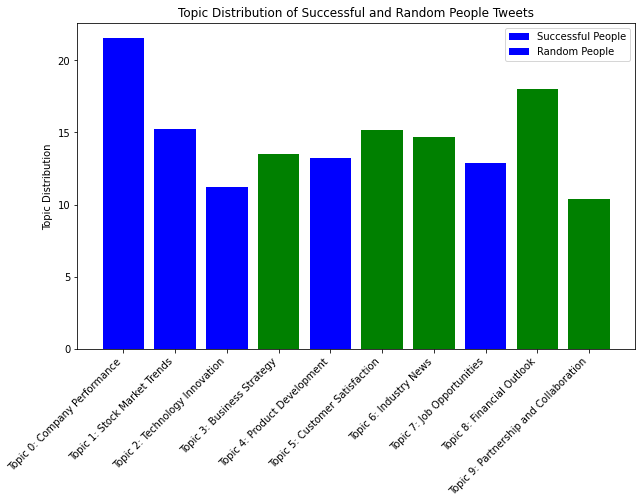

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Set colors for the bars
colors = ['blue' if topic_distribution1.sum(axis=0)[i] > topic_distribution2.sum(axis=0)[i] 
          else ('red' if topic_distribution1.sum(axis=0)[i] == topic_distribution2.sum(axis=0)[i] 
                else 'green') for i in range(len(topic_names))]

# Plot the bars with the colors
ax.bar(np.arange(len(topic_names)), topic_distribution1.sum(axis=0), label='Successful People', color=colors)
ax.bar(np.arange(len(topic_names)), topic_distribution2.sum(axis=0), label='Random People', color=colors)

ax.set_xticks(np.arange(len(topic_names)))
ax.set_xticklabels(topic_names, rotation=45, ha='right')
ax.set_ylabel('Topic Distribution')
ax.set_title('Topic Distribution of Successful and Random People Tweets')
ax.legend()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Set colors for the bars
color1 = 'darkorange'
color2 = 'cornflowerblue'

# Plot the bars with the colors
ax.bar(np.arange(len(topic_names)), topic_distribution1.sum(axis=0), label='Successful People', color=color1)
ax.bar(np.arange(len(topic_names)), topic_distribution2.sum(axis=0), label='Random People', color=color2)

ax.set_xticks(np.arange(len(topic_names)))
ax.set_xticklabels(topic_names, rotation=45, ha='right')
ax.set_ylabel('Topic Distribution')
ax.set_title('Amazon-Topic Distribution of Successful and Random People Tweets')
ax.legend()
plt.show()


NameError: name 'plt' is not defined

In [4]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.3 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving cleaned_MSFT.csv to cleaned_MSFT.csv


In [6]:
from google.colab import files
uploaded = files.upload()


Saving randomcleaned_MSFT.csv to randomcleaned_MSFT.csv


In [7]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import transformers
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the dataset
tweets_df = pd.read_csv('randomcleaned_MSFT.csv')
tweets_df = tweets_df.dropna(subset=['text'])

# Load the BERT model and tokenizer


In [8]:


# Load the BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(model_name)
print(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

<ipython-input-21-3ab904f34cd3>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_ids = np.array(encoded_texts)
<ipython-input-21-3ab904f34cd3>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Topic 0: Company Performance
microsoft today amp thank us important joining world dynamics done
Topic 1: Stock Market Trends
microsoft xbox game together azure power data bing first flight
Topic 2: Technology Innovation
microsoft amp ##s today us people ##ub cloud em power
Topic 3: Business Strategy
microsoft cloud help new customers capabilities work teams together announcing
Topic 4: Product Development
microsoft new help today work world teams customers together across
Topic 5: Customer Satisfaction
microsoft cloud welcome thrilled ai less newest opportunity partner people
Topic 6: Industry News
microsoft amp every new ##power ##rity training ##se black ##tory
Topic 7: Job Opportunities
microsoft thanks cloud sharing thank together students forward welcome visiting
Topic 8: Financial Outlook
microsoft new help ##s open ai teams health source azure
Topic 9: Partnership and Collaboration
amp microsoft cloud thanks making em proud much help always


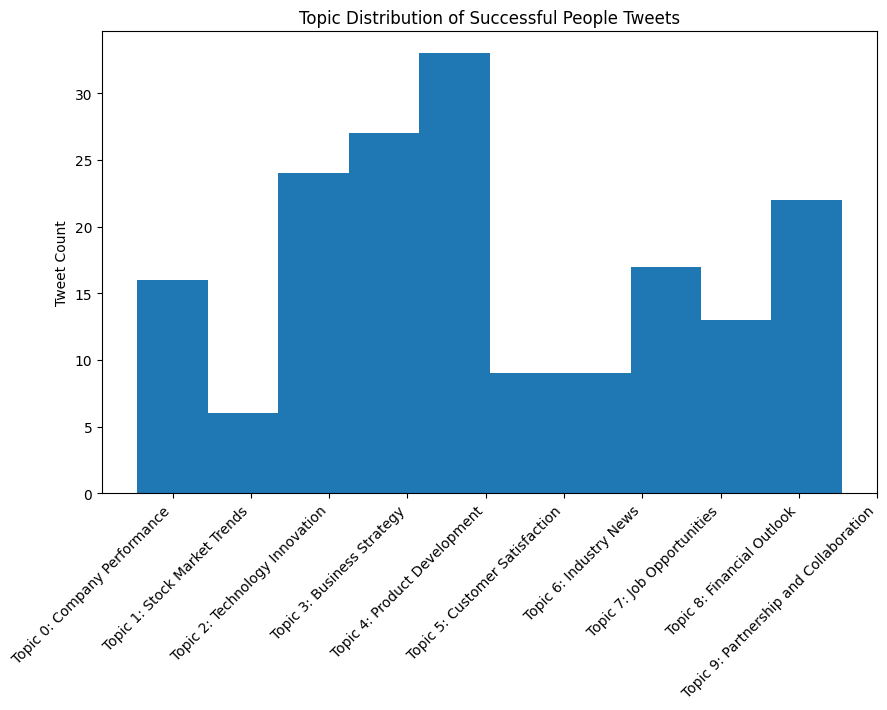

In [9]:
# Encode the text data using BERT
encoded_texts = []
for text in tweets_df['text']:
    encoded_text = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
    encoded_texts.append(encoded_text)

In [11]:
# Get the embeddings for the encoded texts
import torch
input_ids = np.array(encoded_texts)
input_ids = np.array([i + [0]*(512-len(i)) for i in input_ids])
input_ids = torch.tensor(input_ids)
input_ids = torch.tensor(input_ids)
with torch.no_grad():
    embeddings = model(input_ids)[0][:, 0, :].numpy()

<ipython-input-11-c359c34453b4>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_ids = np.array(encoded_texts)
<ipython-input-11-c359c34453b4>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Topic 0: Company Performance
tech ##erton se companies cock tara jimmy ke knight business
Topic 1: Stock Market Trends
microsoft new bing ##t ##s compete creator dal e features
Topic 2: Technology Innovation
microsoft ai loose lets learning narrows l kicks uk genera
Topic 3: Business Strategy
microsoft bing chat ai powered ##bot stem trade cloud surface
Topic 4: Product Development
microsoft teams new ##cha meetings mobile performance power powered probe
Topic 5: Customer Satisfaction
##s apps microsoft ##com ti store services plan of mu
Topic 6: Industry News
microsoft competitor launches loop notion preview public edge galaxy grateful
Topic 7: Job Opportunities
##oid another booster call cloud company deal duty gaming microsoft
Topic 8: Financial Outlook
tech company amp women minority big london mission listing names
Topic 9: Partnership and Collaboration
##s women ##ech ##int free girls partner tech read proud


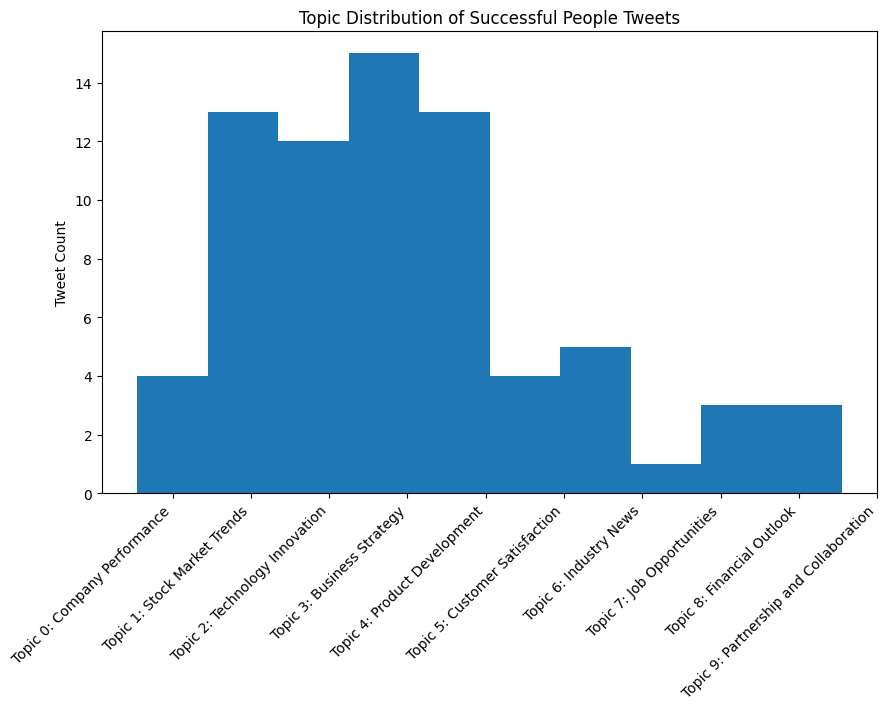

In [12]:
# Cluster the embeddings using k-means
k = 10
kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
topic_names = ['Topic 0: Company Performance', 'Topic 1: Stock Market Trends', 'Topic 2: Technology Innovation', 'Topic 3: Business Strategy', 'Topic 4: Product Development', 'Topic 5: Customer Satisfaction', 'Topic 6: Industry News', 'Topic 7: Job Opportunities', 'Topic 8: Financial Outlook', 'Topic 9: Partnership and Collaboration']
# Get the top keywords for each cluster
keywords = np.array(tokenizer.get_vocab().keys())
topic_keywords = []
for i in range(k):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    cluster_texts = tweets_df.iloc[cluster_indices]['text']
    cluster_keywords = []
    for text in cluster_texts:
        keywords_indices = np.array(tokenizer.encode(text, add_special_tokens=True)).flatten()
        keywords = tokenizer.convert_ids_to_tokens(keywords_indices)
        keywords = [keyword for keyword in keywords if keyword != '[CLS]' and keyword != '[SEP]']
        cluster_keywords += keywords
    cluster_keywords = np.array(cluster_keywords)
    unique_keywords, keyword_counts = np.unique(cluster_keywords, return_counts=True)
    top_keyword_indices = (-keyword_counts).argsort()[:10]
    topic_keywords.append(unique_keywords[top_keyword_indices])

for i, topic in enumerate(topic_keywords):
    print(topic_names[i])
    print(" ".join(topic))


# Create a bar plot of topic distribution
topic_distribution = kmeans.predict(embeddings)
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(topic_distribution, bins=k, align='left')
ax.set_xticks(range(k))
ax.set_xticklabels(topic_names, rotation=45, ha='right')
ax.set_ylabel('Tweet Count')
ax.set_title('Topic Distribution of Successful People Tweets')
plt.show()


In [13]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/base_command.py", line 160, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/req_command.py", line 241, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/commands/install.py", line 499, in run
    conflicts = self._determine_conflicts(to_inst

In [14]:
from google.colab import files
uploaded = files.upload()

Saving cleaned_MSFT.csv to cleaned_MSFT.csv


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-15-0700ed017bac>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuple

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Topic 0: Company Performance
microsoft today amp thank us important joining world dynamics done
Topic 1: Stock Market Trends
microsoft xbox game together azure power data bing first flight
Topic 2: Technology Innovation
microsoft amp ##s today us people ##ub cloud em power
Topic 3: Business Strategy
microsoft cloud help new customers capabilities work teams together announcing
Topic 4: Product Development
microsoft new help today work world teams customers together across
Topic 5: Customer Satisfaction
microsoft cloud welcome thrilled ai less newest opportunity partner people
Topic 6: Industry News
microsoft amp every new ##power ##rity training ##se black ##tory
Topic 7: Job Opportunities
microsoft thanks cloud sharing thank together students forward welcome visiting
Topic 8: Financial Outlook
microsoft new help ##s open ai teams health source azure
Topic 9: Partnership and Collaboration
amp microsoft cloud thanks making em proud much help always


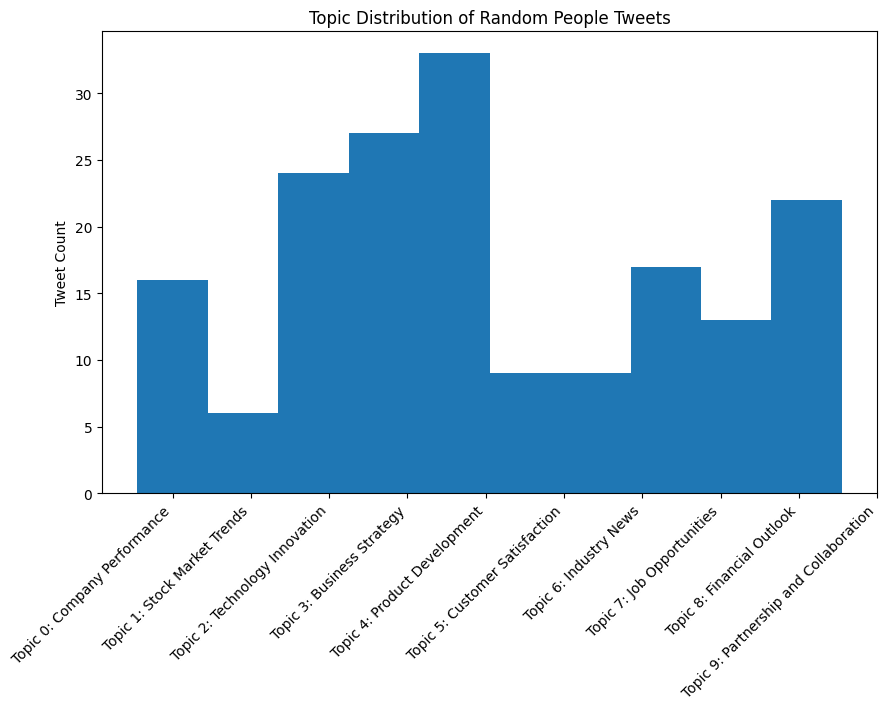

In [15]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import transformers
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the dataset
tweets_df = pd.read_csv('cleaned_MSFT.csv')
tweets_df = tweets_df.dropna(subset=['text'])

# Load the BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(model_name)
print(model)
# Encode the text data using BERT
encoded_texts = []
for text in tweets_df['text']:
    encoded_text = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
    encoded_texts.append(encoded_text)
    # Get the embeddings for the encoded texts
import torch
input_ids = np.array(encoded_texts)
input_ids = np.array([i + [0]*(512-len(i)) for i in input_ids])
input_ids = torch.tensor(input_ids)
input_ids = torch.tensor(input_ids)
with torch.no_grad():
    embeddings = model(input_ids)[0][:, 0, :].numpy()
# Cluster the embeddings using k-means
k = 10
kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
topic_names = ['Topic 0: Company Performance', 'Topic 1: Stock Market Trends', 'Topic 2: Technology Innovation', 'Topic 3: Business Strategy', 'Topic 4: Product Development', 'Topic 5: Customer Satisfaction', 'Topic 6: Industry News', 'Topic 7: Job Opportunities', 'Topic 8: Financial Outlook', 'Topic 9: Partnership and Collaboration']
# Get the top keywords for each cluster
keywords = np.array(tokenizer.get_vocab().keys())
topic_keywords = []
for i in range(k):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    cluster_texts = tweets_df.iloc[cluster_indices]['text']
    cluster_keywords = []
    for text in cluster_texts:
        keywords_indices = np.array(tokenizer.encode(text, add_special_tokens=True)).flatten()
        keywords = tokenizer.convert_ids_to_tokens(keywords_indices)
        keywords = [keyword for keyword in keywords if keyword != '[CLS]' and keyword != '[SEP]']
        cluster_keywords += keywords
    cluster_keywords = np.array(cluster_keywords)
    unique_keywords, keyword_counts = np.unique(cluster_keywords, return_counts=True)
    top_keyword_indices = (-keyword_counts).argsort()[:10]
    topic_keywords.append(unique_keywords[top_keyword_indices])

for i, topic in enumerate(topic_keywords):
    print(topic_names[i])
    print(" ".join(topic))


# Create a bar plot of topic distribution
topic_distribution2 = kmeans.predict(embeddings)
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(topic_distribution2, bins=k, align='left')
ax.set_xticks(range(k))
ax.set_xticklabels(topic_names, rotation=45, ha='right')
ax.set_ylabel('Tweet Count')
ax.set_title('Topic Distribution of Random People Tweets')
plt.show()

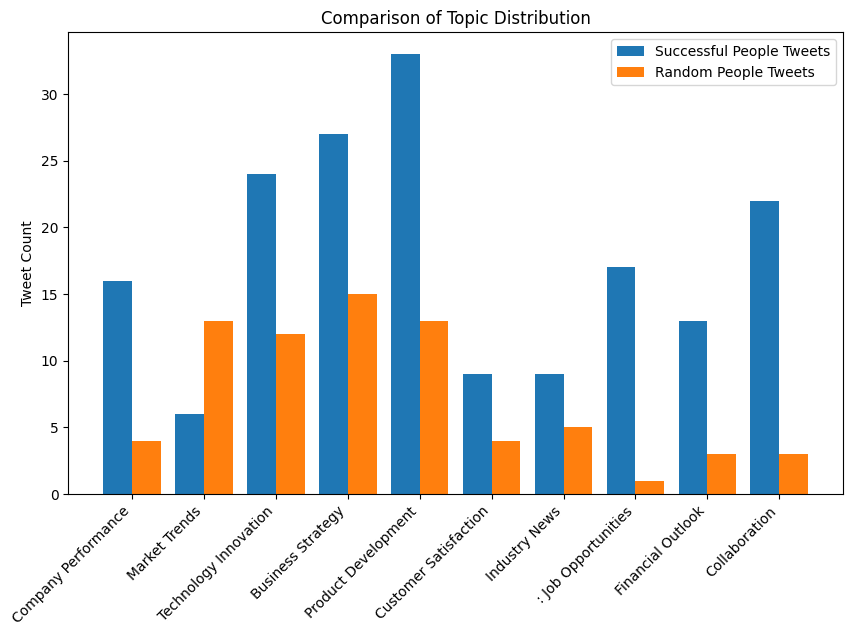

In [20]:
topic_names = ['Company Performance', 'Market Trends','Technology Innovation', 'Business Strategy', 'Product Development', 'Customer Satisfaction', 'Industry News', ': Job Opportunities', 'Financial Outlook', 'Collaboration']

# Count the number of tweets in each topic for both distributions
topic_counts1 = np.zeros(k)
for i in range(k):
    topic_counts1[i] = np.sum(topic_distribution2 == i)#sucessgful
    
topic_counts2 = np.zeros(k)
for i in range(k):
    topic_counts2[i] = np.sum(topic_distribution == i)

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
ax.bar(np.arange(k)-bar_width/2, topic_counts1, bar_width, label='Successful People Tweets')
ax.bar(np.arange(k)+bar_width/2, topic_counts2, bar_width, label='Random People Tweets')
ax.set_xticks(range(k))
ax.set_xticklabels(topic_names, rotation=45, ha='right')
ax.set_ylabel('Tweet Count')
ax.set_title('Comparison of Topic Distribution')
ax.legend()
plt.show()
